In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import t as student_t
from scipy import integrate
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score  
import matplotlib.pyplot as plt
import math
from typing import Callable, Tuple, List, Dict, Literal

In [2]:
from statsmodels import robust 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd 

# I- Dynamic programming functions

In [4]:

QuadPiece = Tuple[float, float, float, float, float, int]
#quadpiece is a tuple containing:
#first float a = left bound of the interval
#second flat b: right bound of the interval
#3 other floats A,B,C = coefficients of the quadratic polynom on interval [a,b]: AX^2+BX=c 
#last int tau = index of last changepoint 


#algorithm 2 from appendix D 
def rfpop_algorithm2_add_Qstar_and_gamma(Qstar_pieces: List[QuadPiece], 
                                         #Q_star est représenté sous forme [ (a1,b1,A1,B1,C1,tau1), (a2,b2,A2,B2,C2,tau2), ..., ]
                                         gamma_pieces: List[QuadPiece]):

    out: List[QuadPiece] = []
    i = 0
    j = 0
    while i < len(Qstar_pieces) and j < len(gamma_pieces):
        pa, pb, pA, pB, pC, p_tau = Qstar_pieces[i]
        ga, gb, gA, gB, gC, g_tau = gamma_pieces[j]

        #new interval 
        a = max(pa, ga)
        b = min(pb, gb)
        
        # sum of Q_star and gamma on the new interval
        newA = pA + gA
        newB = pB + gB
        newC = pC + gC
        # tau comes from Q* (p_tau) 
        out.append((a, b, newA, newB, newC, p_tau))
        # avancer indices selon bornes
        if abs(b - pb) < 1e-12:
            i += 1
        if abs(b - gb) < 1e-12:
            j += 1
        # to avoid infinite loop
        if (i < len(Qstar_pieces) and j < len(gamma_pieces)) and a >= b - 1e-14 and abs(b - Qstar_pieces[i][1]) > 1e-12 and abs(b - gamma_pieces[j][1]) > 1e-12:
            break
    # to do as they say on page 12 and merge identical neighbouring intervals
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged



In [5]:
#algorithm 3 from pseudocode 
def rfpop_algorithm3_min_over_theta(Qt_pieces: List[QuadPiece]):
    best_val = float('inf')
    best_tau = 0
    for (a,b,A,B,C,tau) in Qt_pieces:
        # computing min of Q_t(theta) over segment (a,b]
        if abs(A) < 1e-16:
            #if the coefficient associated with x^2 of the quadratic function is =0 then the function is linear (B!=0) or constant (B=0)
            #hence in this case min value of Q_t(theta) is on the boundaries of the segment
            left = a + 1e-12 #because segment does not contain a 
            right = b
            vleft = A*left*left + B*left + C
            vright = A*right*right + B*right + C
            theta_star = left if vleft <= vright else right
        else: #if A!=0 then Q_t(theta) =A theta^2 + B theta + C on segment (a,b] 
            #so minimizer is -B/2A   (each quadratic is assumed convex, not concave so not a maximizer)
            theta_star = -B / (2.0 * A)
            #we need to ensure the minimizer is in (a,b]
            if theta_star <= a: 
                theta_star = a + 1e-12
            elif theta_star > b:
                theta_star = b
        val = A*theta_star*theta_star + B*theta_star + C
        if val < best_val:
            best_val = val
            best_tau = tau
    return float(best_val), int(best_tau)

In [6]:
#algorithm 4

def rfpop_algorithm4_prune_compare_to_constant(Qt_pieces: List[QuadPiece],
                                               Qt_val: float, #Qt_val + beta = the constant C in appendix
                                               beta: float,
                                               t_index_for_new: int):
   
    thr = Qt_val + beta
    out: List[QuadPiece] = []

    #goes through the Nt intervals of Qt
    for (a,b,A,B,C,tau) in Qt_pieces:
        #finds the roots of Q_t(x) - C ie the roots of A x^2 + B x + (C - thr) = 0 on [a,b]
        # BEWARE: source of confuction: thr is the equivalent of the constant C in the pseudocode of the paper
        # C is the last coefficient of the quadratic function, not the constant C defined in the pseudocode 
        roots: List[float] = []
        if abs(A) < 1e-16:
            # if the quadratic function is linear or constant: B x + (C - thr) = 0
            if abs(B) > 1e-16:
                x = -(C - thr) / B
                #we need to ensure root x is in interval [a,b] otherwise we don't care about it 
                if x + 1e-12 >= a and x - 1e-12 <= b:
                    x_clamped = max(min(x, b), a) #to ensure the root is indeed within the interval and have no problems of numerical errors later: we need to sort the roots it could do weird things later if we don't do that
                    roots.append(x_clamped)
        else:
            #if the function is indeed quadratic we compute delta and roots 
            D = B*B - 4.0*A*(C - thr)
            if D >= -1e-14:
                D = max(D, 0.0)
                sqrtD = math.sqrt(D)
                x1 = (-B - sqrtD) / (2.0*A)
                x2 = (-B + sqrtD) / (2.0*A)
                for x in (x1, x2):
                    if x + 1e-12 >= a and x - 1e-12 <= b:
                        x_clamped = max(min(x, b), a)
                        # avoid duplicates if delta D = 0 we get 2 times the same root 
                        if not any(abs(x_clamped - r) < 1e-9 for r in roots):
                            roots.append(x_clamped)
        roots.sort()
        # create vector [a, r1, r2,  b]
        breaks = [a] + roots + [b]
        for k in range(len(breaks)-1):
            lo = breaks[k]
            hi = breaks[k+1]
            mid = (lo + hi) / 2.0
            #here we evaluate the polynom A*mid*mid + B*mid + C - thr on each subsegment [a,root_1], [root_1,root_2],[root_2,b]
            #on each of these subsegment this polynom has the same sign as each bound of a subsegment is a root 
            #so we can pick an arbitrary value like the middle to see the sign of the polynom on this subsegment
            val_mid = A*mid*mid + B*mid + C - thr 

            #if polynom is negative then Q_t(theta)<constant so we keep Q_t(theta) = A*theta^2 + B*theta + C
            if val_mid <= 1e-12:
                # keep Q_t on this subsegment
                out.append((lo, hi, A, B, C, tau))
            else:
                # keep constant thr in this subsegment and set a changepoint at t_index_for_new 
                out.append((lo, hi, 0.0, 0.0, thr, t_index_for_new))
    # fusionner adjacences égales
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged


In [7]:
#algorithm 1
def rfpop_algorithm1_main(y: List[float], gamma_builder, beta: float):

    y_arr = np.asarray(y, dtype=float)
    n = len(y_arr)

    lo = float(np.min(y_arr)) - 1.0 #we add -1 and +1 to ensure there is no numeric problem with python approximations for foats 
    hi = float(np.max(y_arr)) + 1.0
    Qstar = [(lo, hi, 0.0, 0.0, 0.0, 0)]  # Q*_1
    cp_tau = [0] * n
    Qt_vals = [0.0] * n
    for t_idx in range(n):
        # Sub-routine 2 : Qt = Q*_t + gamma(y_t)
        gamma_pcs = gamma_builder(float(y_arr[t_idx]), t_idx)
        Qt_pcs = rfpop_algorithm2_add_Qstar_and_gamma(Qstar, gamma_pcs)
        # Sub-routine 3 : min over theta Qt
        Qt_val, tau_t = rfpop_algorithm3_min_over_theta(Qt_pcs)
        cp_tau[t_idx] = tau_t
        Qt_vals[t_idx] = Qt_val
        # Sub-routine 4 : compute Q*_{t+1}
        Qstar = rfpop_algorithm4_prune_compare_to_constant(Qt_pcs, Qt_val, beta, t_idx)
    return cp_tau, Qt_vals, Qstar



In [8]:

QuadPiece = Tuple[float, float, float, float, float, int]
INF = 1e18  # borne pratique pour "infty"
EPS = 1e-12

def gamma_builder_L2(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    gamma(y,theta) = (y - theta)^2 = theta^2 - 2*y*theta + y^2
    Single quadratic piece on (-INF, INF].
    """
    A = 1.0
    B = -2.0 * y
    C = y * y
    return [(-INF, INF, A, B, C, tau_for_new)]

def gamma_builder_biweight(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """ :
      gamma(y,theta) = (y-theta)^2   if |y-theta| <= K
                      = K^2         otherwise
    Can be defined as 3 different quadratic functions over 3 segments :
      (-INF, y-K]       : constant K^2
      (y-K, y+K]        : quadratic (y-theta)^2
      (y+K, INF)        : constant K^2
    """
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    constC = float(K * K)
    return [
        (-INF, y - K, 0.0, 0.0, constC, tau_for_new),
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),
        (y + K, INF, 0.0, 0.0, constC, tau_for_new)
    ]


def gamma_builder_huber(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """
    Huber loss with threshold K:
      gamma(y,theta) = (y-theta)^2                     if |y-theta| <= K
                      = 2*K*|y-theta| - K^2           if |y-theta| > K
    
    Can be defined as 3 quadratic functions over 3 segments  
    (-INF, y-K] :  2*K*(y-theta) - K^2 = -2K*theta + (2K*y - K^2)
    (y-K, y+K]: (y-theta)^2 = theta^2 - 2y theta + y^2
    (y+K, INF): 2*K*(theta-y) - K^2 = 2K*theta + (-2K*y - K^2)
    """
    # central quadratic
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    # left linear: B_left * theta + C_left  where B_left = -2K, C_left = 2K*y - K^2
    B_left = -2.0 * K
    C_left = 2.0 * K * y - K * K
    # right linear: B_right * theta + C_right where B_right = 2K, C_right = -2K*y - K^2
    B_right = 2.0 * K
    C_right = -2.0 * K * y - K * K
    return [
        (-INF, y - K, 0.0, B_left, C_left, tau_for_new),   # linear = A=0
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),       # quadratic
        (y + K, INF, 0.0, B_right, C_right, tau_for_new) # linear = A=0
    ]

def gamma_builder_L1(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    L1 loss: gamma(y,theta) = |y - theta|
    Piecewise-linear
      (-INF, y) :  y - theta = (-1)*theta + y
      (y, INF): theta - y = (+1)*theta + (-y)

    """
    # left piece: (-INF, y] -> -theta + y  => A=0, B=-1, C=y
    # right piece: (y, INF] -> theta - y  => A=0, B=1,  C=-y
    return [
        (-INF, y, 0.0, -1.0, float(y), tau_for_new),
        (y, INF, 0.0,  1.0, float(-y), tau_for_new)
    ]


## II - Data for experiments 

In [9]:


def generate_scenarios():

    np.random.seed(42) 

    # Fonction auxiliaire pour le bruit t-student
    def t_noise(n, df=5, sigma=1.0):
        return np.random.standard_t(df, size=n) * sigma

    #scenario 1
    n1 = 2048
    t = np.arange(n1) / n1
    pos = np.array([0.1, 0.13, 0.15, 0.23, 0.25, 0.40, 0.44, 0.65, 0.76, 0.78, 0.81])
    h = np.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])
    sig1 = np.zeros(n1)
    for p, hi in zip(pos, h):
        sig1[int(p * n1):] += hi
    sig1 = sig1 * 3.5 
    y1 = sig1 + t_noise(n1, df=5, sigma=5.0) 

    #Scenario 2
    n2 = 512
    sig2 = np.zeros(n2)
    segments_fms = [
        (0, 200, -0.2), (200, 220, 0.2), (220, 240, 1.2), (240, 260, -0.8),
        (260, 280, 0.5), (280, 400, -0.1), (400, 420, 0.8), (420, 512, -0.3)
    ]
    for start, end, val in segments_fms:
        sig2[start:end] = val
    y2 = sig2 + t_noise(n2, df=5, sigma=0.3)


    # --- Scenario 2'
    # same signal but less noise
    y2_prime = sig2 + t_noise(n2, df=5, sigma=0.2)

    #Scenario 3
    # short and long segments
    n3 = 512
    sig3 = np.zeros(n3)
    curr = 0
    mu = 0
    #alternate randomly between long and short segments 
    while curr < n3:
        length = np.random.choice([10, 20, 80, 100])
        val = np.random.normal(0, 2)
        end = min(curr + length, n3)
        sig3[curr:end] = val
        curr = end

    y3 = sig3 + t_noise(n3, df=5, sigma=0.3)


    #Scenario 4 saw tooth 
    n4 = 240
    sig4 = np.zeros(n4)
    n_teeth = 10
    len_tooth = n4 // n_teeth 
    for i in range(n_teeth):
        if i % 2 == 1:
            sig4[i*len_tooth : (i+1)*len_tooth] = 1.0
    y4 = sig4 + t_noise(n4, df=5, sigma=0.3)

    #Scenario 5: Stairs 
    n5 = 150
    sig5 = np.zeros(n5)
    n_steps = 10
    len_step = n5 // n_steps 
    for i in range(n_steps):
        sig5[i*len_step : (i+1)*len_step] = (i + 1) * 1.5
    # Bruit
    y5 = sig5 + t_noise(n5, df=5, sigma=0.3)

    dic1 = {
        "Scenario 1": y1,
        "Scenario 2": y2,
        "Scenario 2'": y2_prime,
        "Scenario 3": y3,
        "Scenario 4": y4,
        "Scenario 5": y5}
    dic2 = {
        "Scenario 1": sig1,
        "Scenario 2": sig2,
        "Scenario 2'": sig2,
        "Scenario 3": sig3,
        "Scenario 4": sig4,
        "Scenario 5": sig5}
    return dic1,dic2



data, true_signals = generate_scenarios()


## III- Reproducing the experiments 

We should pick K and beta optimally as in the paper: 
$$K = \begin{cases}
                3 \hat \sigma \quad \text{for the biweight loss}, \\
                1.345 \hat \sigma \quad \text{for the huber loss}
            \end{cases} $$


Where $\hat \sigma$ is the median absolute deviation of the differenced time series. 


$$ \beta = 2 \hat \sigma^2\text{log}(n) \mathbb E(\phi(Z)^2)$$

Where $\phi$ is the gradient of the loss function and $Z \sim \mathcal N(0,1)$

#### Important: 
- the ratio $\beta/K$ represents the minimum length of segments chosen by the algorithm. 
- when data is such that the ratio $\beta/K$ is too small, the model will overfit the data and detect too many changepoints. In particular, in extreme cases, \$beta/K$ can be lower than 1 and then the algorithms will consider simple outliers as a segment, resulting in many changepoints. 
- as a result, we consider that if $\beta/K \leq len(y)/100$, the minimum segment size will be too small. In that case, we manually adjust the $\beta$ so that $\beta = Klen(y)/100$. 

In [10]:
#function to compute parameter K
def compute_loss_bound_K(y,
             loss: Literal['huber','biweight']):
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())
    if loss == "biweight":
        return 3*mad
    elif loss == 'huber':
        return 1.345*mad 



#functions necessary to compute optimal beta according to schwarz information criteria 
#we now need to introduce a few auxiliary functions to compute the optimal beta from the paper:
#indeed we need to compute E(phi(Z)^2) where phi is the gradient of the loss function used: this implies doing numerical approximations

# Huber loss gradient definition for integration
def huber_gradient(z, K):
    return z if abs(z) <= K else math.copysign(K, z)

# biweight loss gradient definition for integration
def biweight_gradient(z, K):
    return z if abs(z) <= K else 0


# function to integrate that will be used to approximate E(phi(Z)^2)
def integrand_phi2(phi_func, z, K):
    return (phi_func(z, K)**2) * norm.pdf(z)



# def compute_E_phi2(phi_func, #either huber_gradient or biweight_gradient 
#                    K):
#     E_phi2, _ = integrate.quad(lambda z: integrand_phi2(phi_func, z, K), -np.inf, np.inf,
#                                 epsabs=1e-9, epsrel=1e-9, limit=200)
    
#     return float(E_phi2)

def compute_penalty_beta(y,
                         loss: Literal['huber','biweight','l2','l1']
                         ):
    
    """
    page 16 of the paper: optimal beta according to schwarz information criteria is beta = 2 \hat{\sigma}^2 log(n) E(phi(Z)^2)
    where:
    \hat{\sigma} = median absolute deviation of the differentiated time series y = estimator of variance of the noise
    n = length of time series 
    phi = gradient of the loss function used 
    Z = a N(0,I)

    for L2 loss p(z) = z^2/2, phi(z)=z so E(phi(Z)^2) = E(Z^2) = 1
    for huber and biweight loss, E(phi(Z)^2) is approximated numerically 
    for L1 loss we can't apply the formula of the paper as E(phi(Z)^2) = 0 so we arbitrarly pick beta = log(n)
    """
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())

    if loss == 'l2':
        return 2*mad*mad*np.log(len(y))

    elif loss == 'huber':

        K = compute_loss_bound_K(y,'huber')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(huber_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'biweight':
        
        K = compute_loss_bound_K(y,'biweight')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(biweight_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'l1':
        return np.log(len(y))


## Without the clipping rule for $\beta/K$

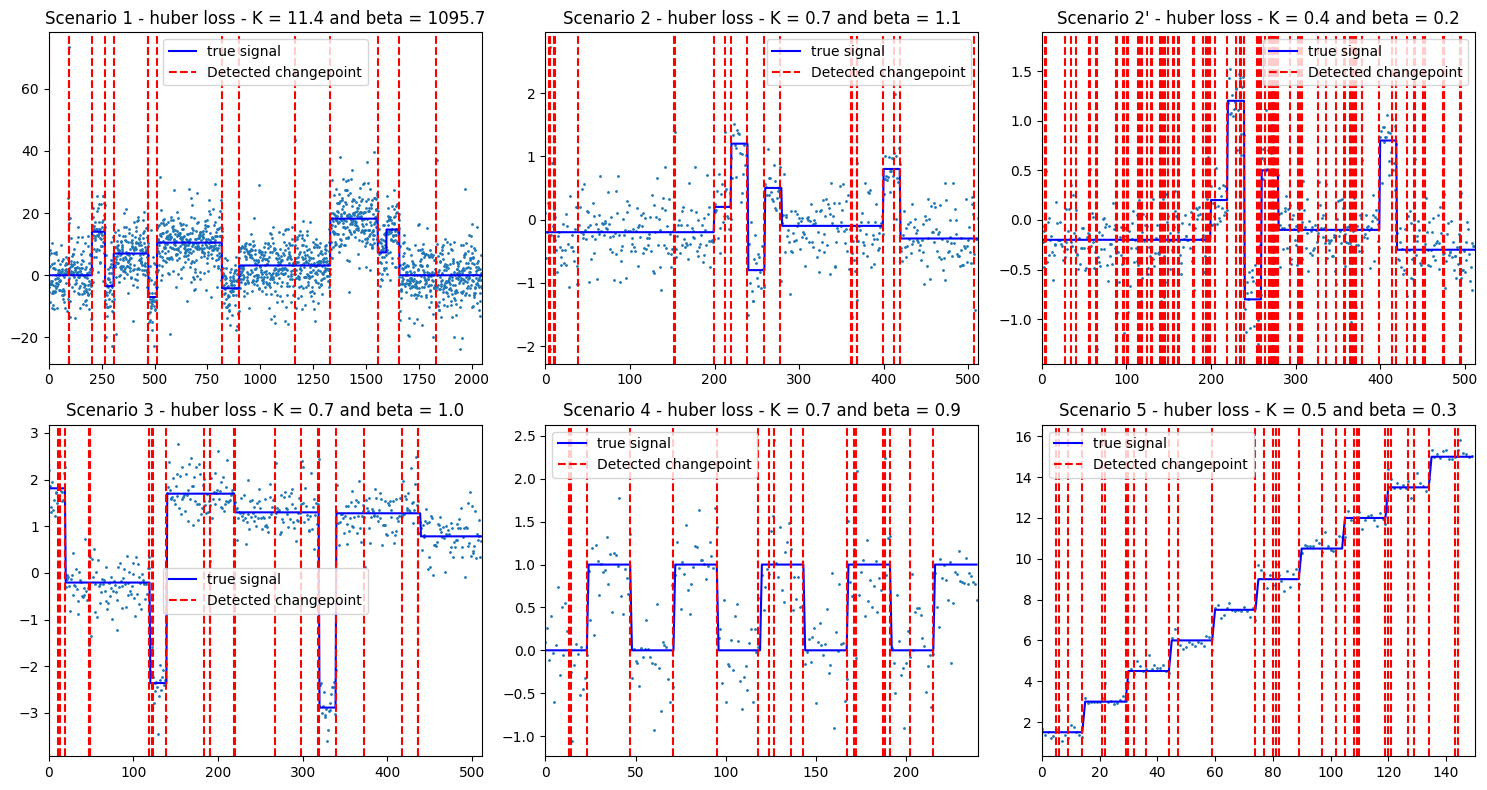

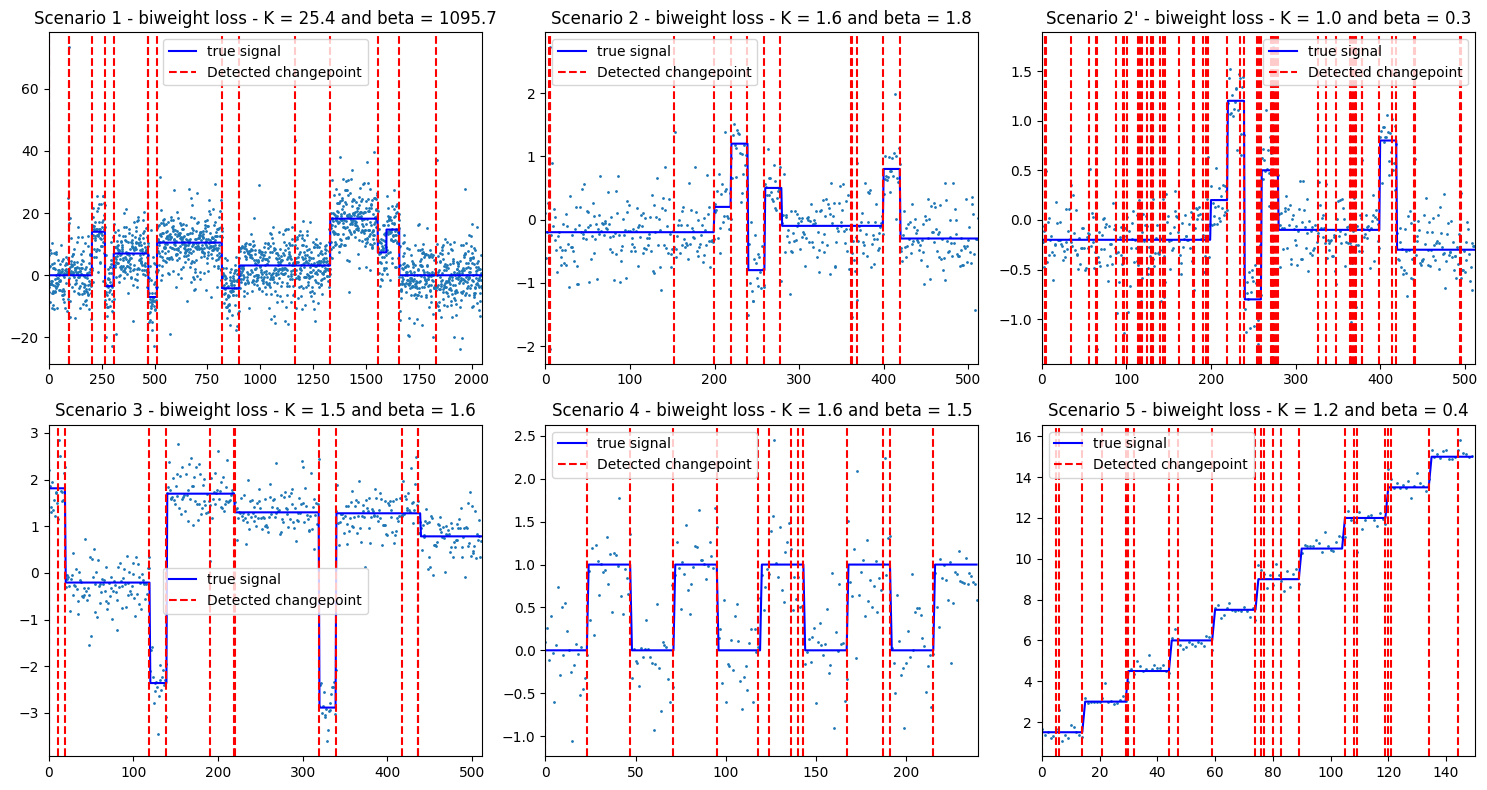

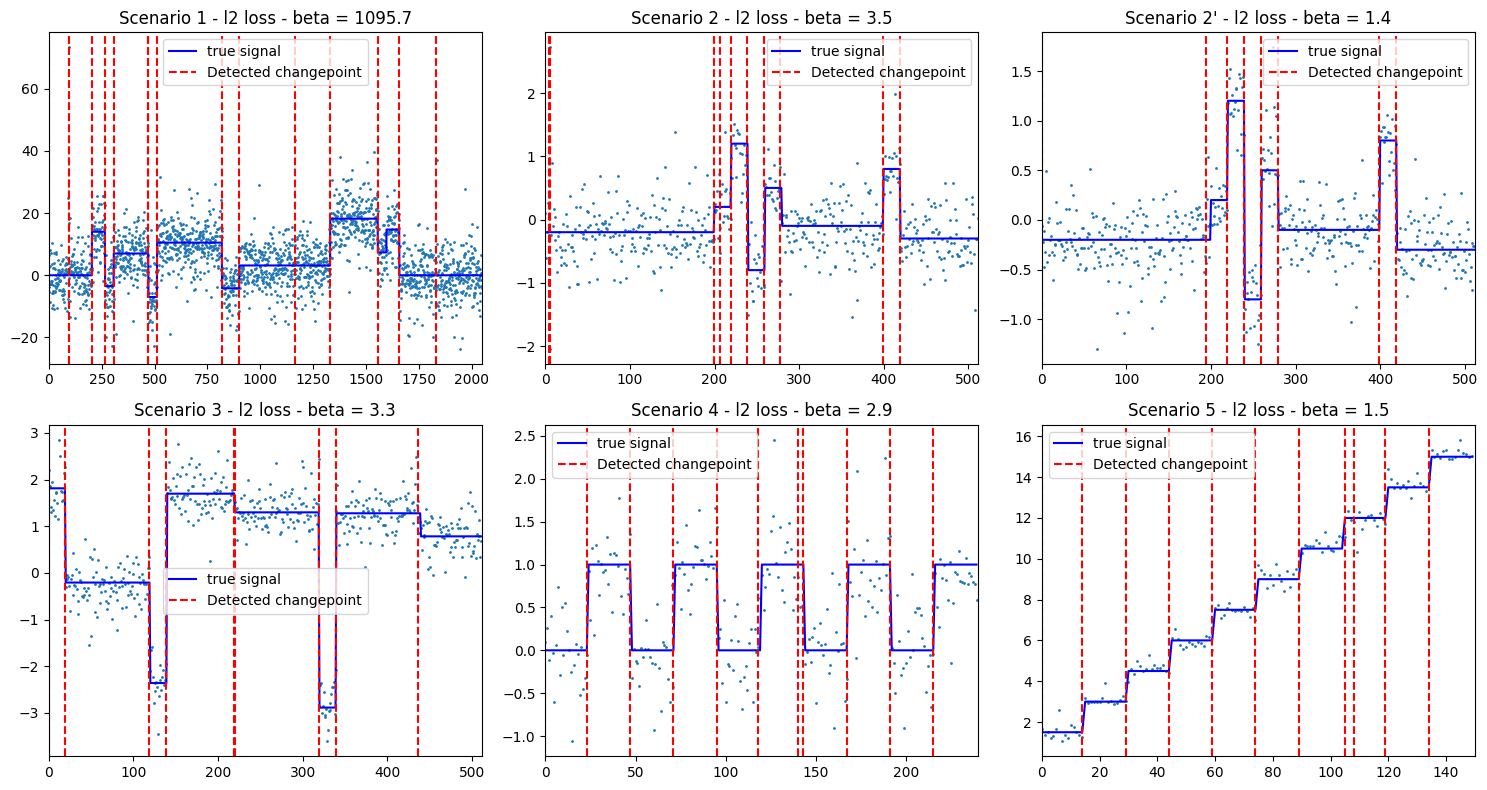

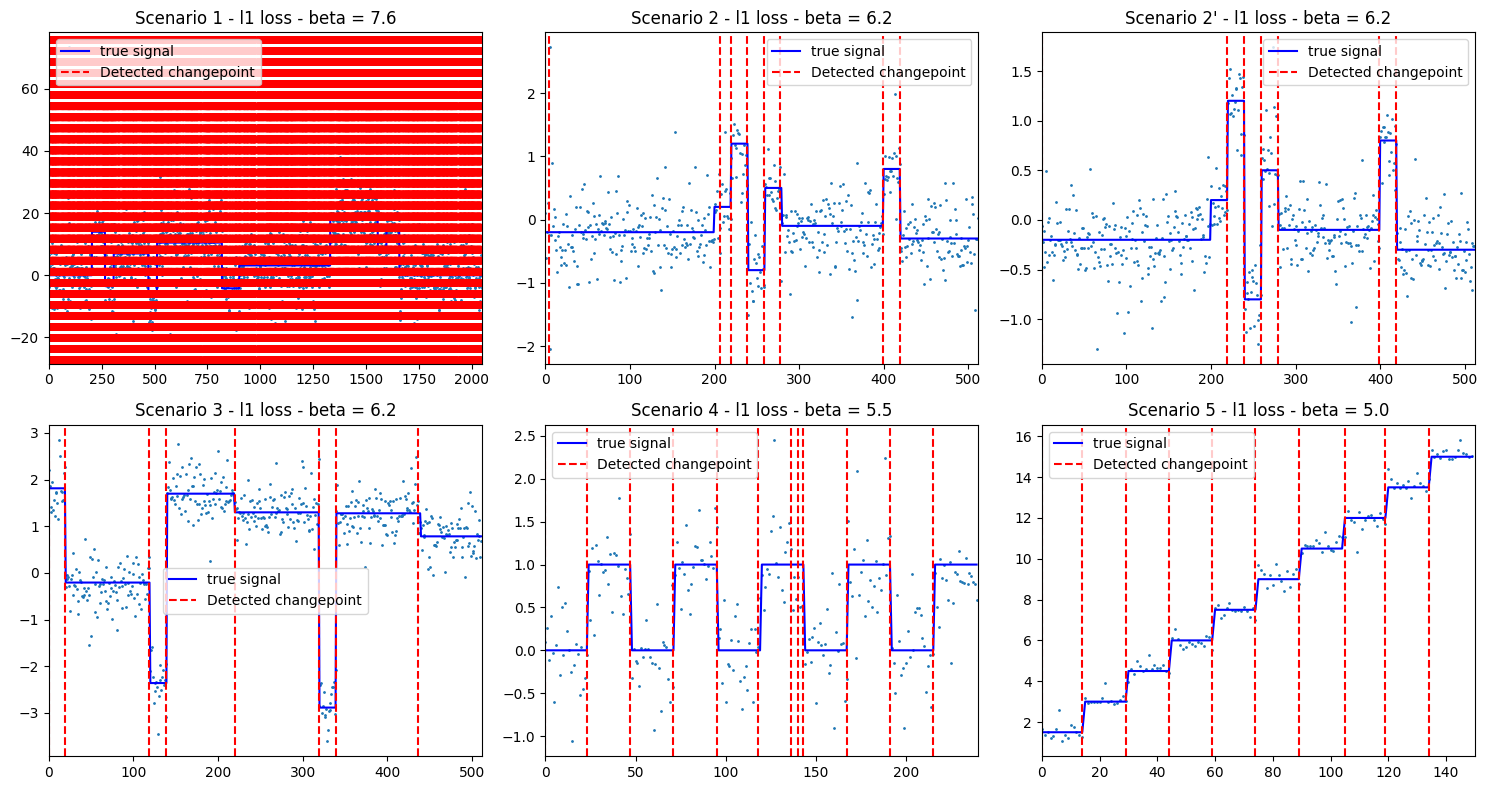

In [11]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)



        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label = 'true signal',color = 'blue')
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

We can indeed see that the Huber and biweight losses are not that robust when $\beta/K$ is too small (for instance scenario 3 of the biweight loss with a ratio <1). When the ratio is too small, unbounded losses like $\ell_2$ and $\ell_1$ even perform better. 

## Avec ajout de la règle de clipping de $\beta/K$

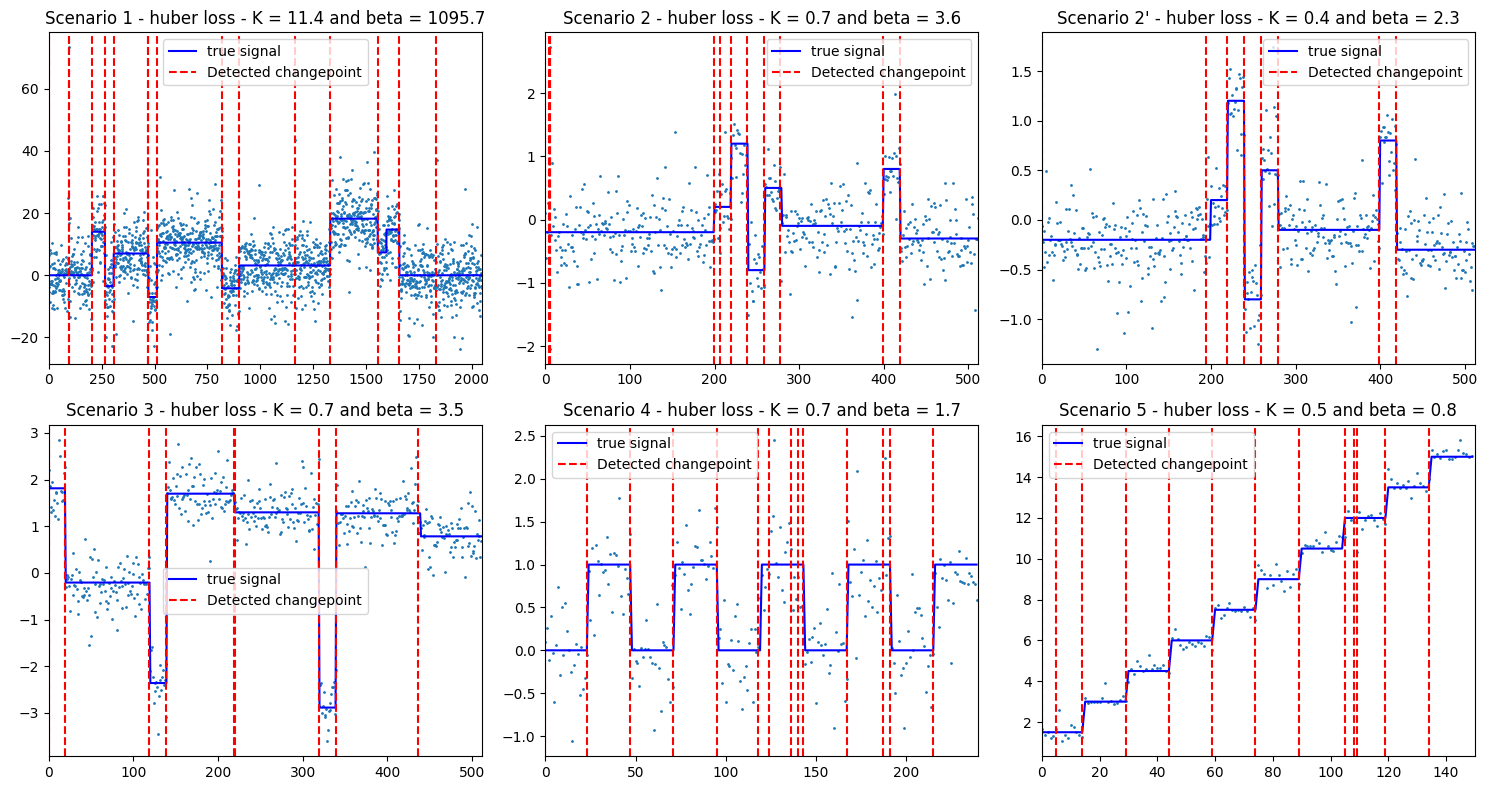

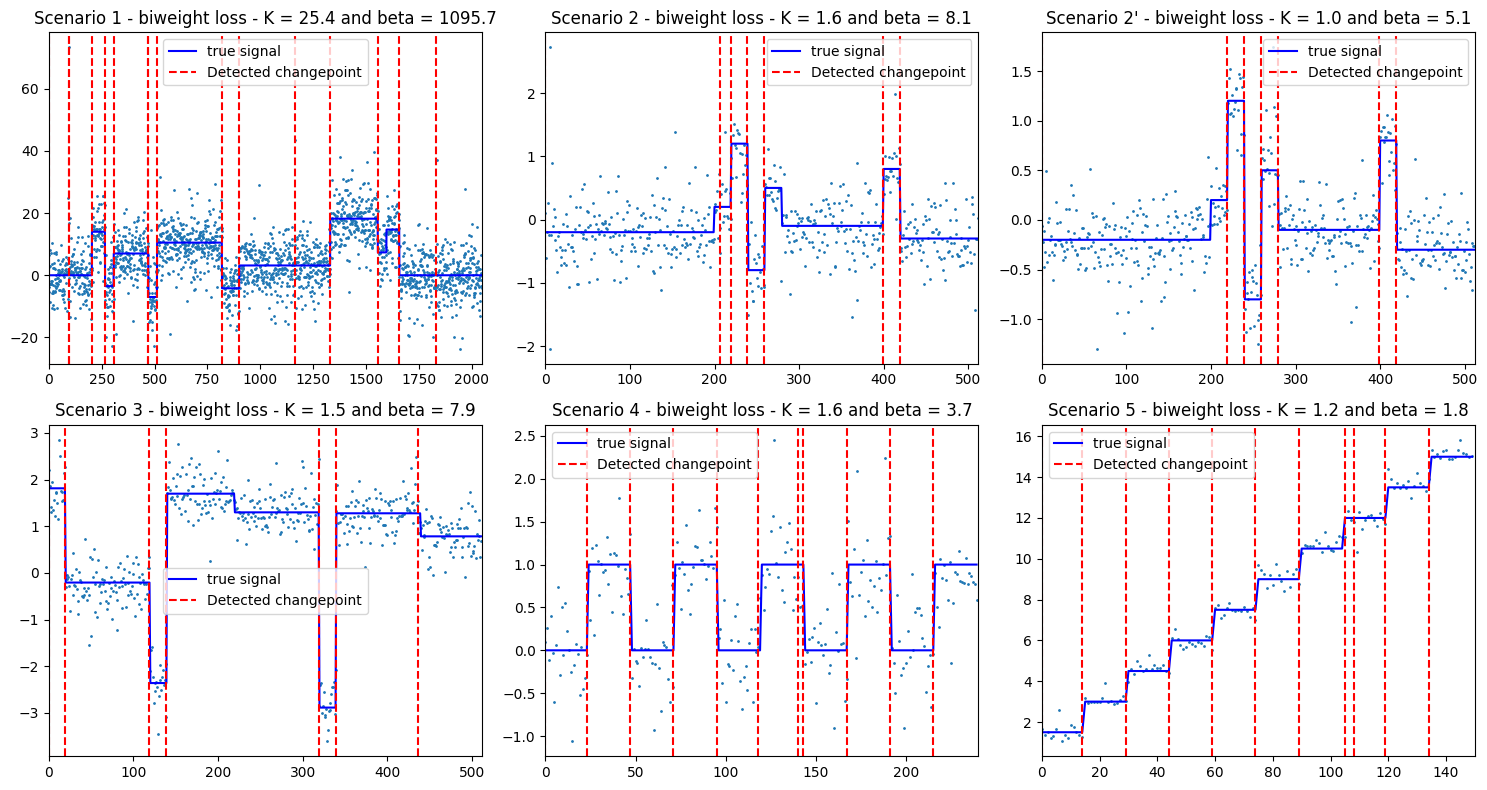

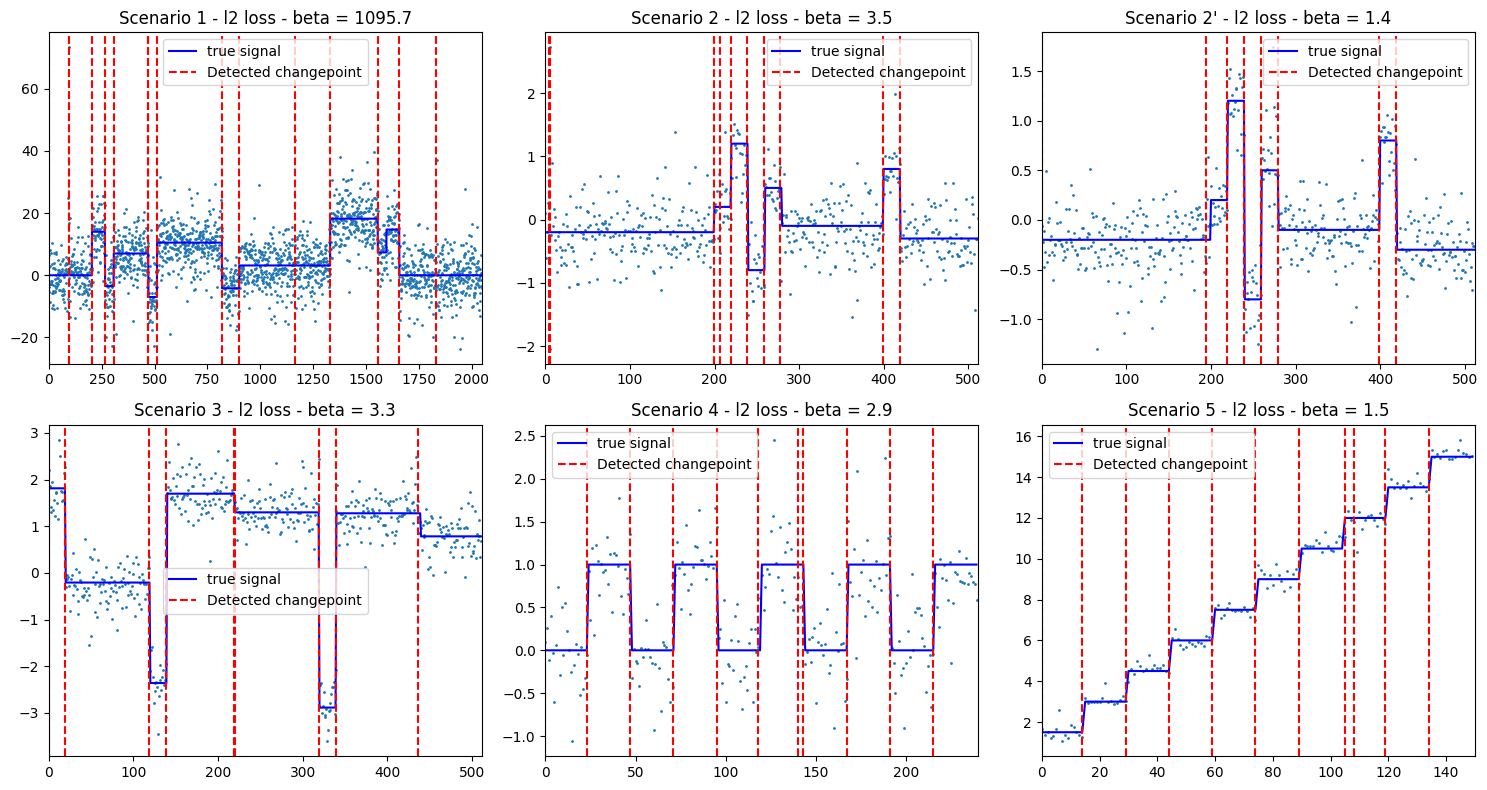

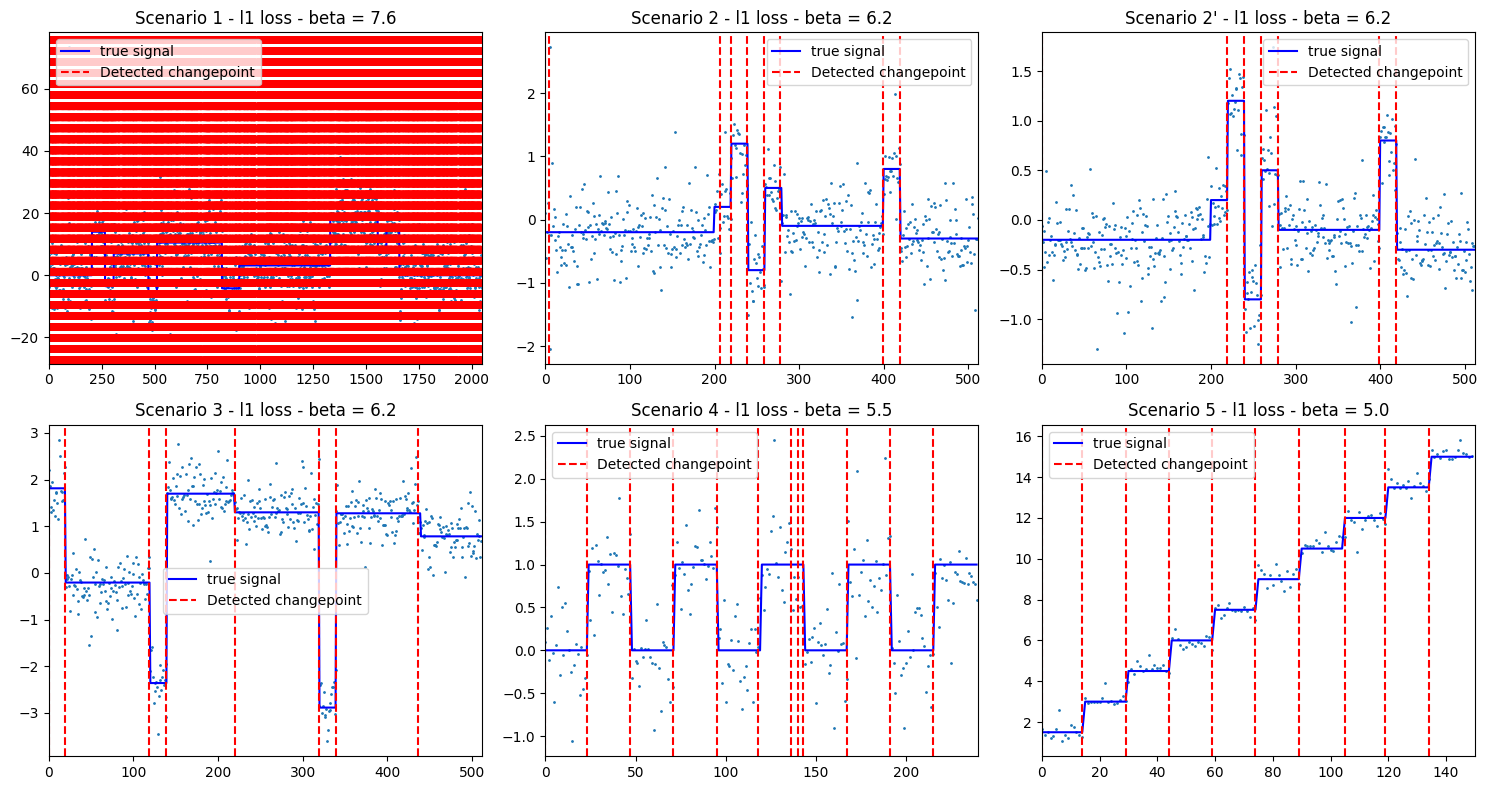

In [12]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)

        if K:
            if beta/K < len(y)/100:
                beta = K*len(y)/100


        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label = 'true signal',color = 'blue')
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

We can see a real improvement with this clipping rule.

### Cross Validation

We cross validate beta and K, using different losses

In [13]:
from itertools import product
from typing import Optional, Union, Callable

def get_gamma_builder(loss: Literal['huber', 'biweight', 'l2', 'l1'], K: Optional[float] = None):
    """
    Returns the appropriate gamma builder function for the specified loss.
    
    Parameters:
    -----------
    loss : str
        Type of loss function ('huber', 'biweight', 'l2', 'l1')
    K : float, optional
        Threshold parameter for robust losses (Huber, Biweight)
        
    Returns:
    --------
    Callable : gamma builder function compatible with rfpop_algorithm1_main
    """
    if loss == 'l2':
        return lambda y_t, t: gamma_builder_L2(y_t, t)
    elif loss == 'l1':
        return lambda y_t, t: gamma_builder_L1(y_t, t)
    elif loss == 'huber':
        if K is None:
            raise ValueError("K must be provided for Huber loss")
        return lambda y_t, t: gamma_builder_huber(y_t, K, t)
    elif loss == 'biweight':
        if K is None:
            raise ValueError("K must be provided for Biweight loss")
        return lambda y_t, t: gamma_builder_biweight(y_t, K, t)
    else:
        raise ValueError(f"Unknown loss: {loss}")


def compute_segment_labels(cp_tau: List[int], n: int) -> np.ndarray:
    """
    Convert changepoint indices to segment labels for ARI computation.
    
    Parameters:
    -----------
    cp_tau : List[int]
        Changepoint indices from RFPOP algorithm
    n : int
        Length of the time series
        
    Returns:
    --------
    np.ndarray : Segment labels (0, 1, 2, ...) for each time point
    """
    labels = np.zeros(n, dtype=int)
    changepoints = sorted(set(cp_tau))
    
    # Reconstruct segments from changepoint backtrack
    current_label = 0
    prev_cp = 0
    for cp in changepoints:
        if cp > prev_cp:
            labels[prev_cp:cp] = current_label
            current_label += 1
            prev_cp = cp
    labels[prev_cp:] = current_label
    
    return labels


def compute_true_segment_labels(true_signal: np.ndarray) -> np.ndarray:
    """
    Compute segment labels from the true signal (for ARI computation).
    
    Parameters:
    -----------
    true_signal : np.ndarray
        The true underlying signal
        
    Returns:
    --------
    np.ndarray : Segment labels for each time point
    """
    labels = np.zeros(len(true_signal), dtype=int)
    current_label = 0
    current_value = true_signal[0]
    
    for i, val in enumerate(true_signal):
        if abs(val - current_value) > 1e-9:
            current_label += 1
            current_value = val
        labels[i] = current_label
    
    return labels


def run_rfpop_with_params(y: np.ndarray, 
                          loss: Literal['huber', 'biweight', 'l2', 'l1'],
                          beta: float,
                          K: Optional[float] = None) -> dict:
    """
    Run RFPOP algorithm with specified parameters and return results.
    
    Parameters:
    -----------
    y : np.ndarray
        Time series data
    loss : str
        Loss function type
    beta : float
        Penalty parameter
    K : float, optional
        Threshold for robust losses
        
    Returns:
    --------
    dict : Results including cp_tau, Qt_vals, total_cost, n_changepoints
    """
    gamma_builder = get_gamma_builder(loss, K)
    cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(list(y), gamma_builder, beta)
    
    changepoints = np.unique(cp_tau)
    n_changepoints = len(changepoints) - 1  # Exclude 0
    
    return {
        'cp_tau': cp_tau,
        'Qt_vals': Qt_vals,
        'Qstar_final': Qstar_final,
        'total_cost': Qt_vals[-1],
        'n_changepoints': n_changepoints,
        'changepoints': changepoints
    }


def cv_changepoint_params(
    y: np.ndarray,
    loss: Literal['huber', 'biweight', 'l2', 'l1'],
    beta_grid: Optional[np.ndarray] = None,
    K_grid: Optional[np.ndarray] = None,
    beta_multipliers: Optional[np.ndarray] = None,
    K_multipliers: Optional[np.ndarray] = None,
    true_signal: Optional[np.ndarray] = None,
    criterion: Literal['total_cost', 'bic', 'ari', 'elbow'] = 'bic',
    verbose: bool = True
) -> dict:
    """
    Cross-validation for changepoint detection parameters.
    
    This function performs a grid search over beta and K parameters to find
    the optimal combination based on the specified criterion.
    
    Parameters:
    -----------
    y : np.ndarray
        Time series data
    loss : str
        Loss function type ('huber', 'biweight', 'l2', 'l1')
    beta_grid : np.ndarray, optional
        Explicit grid of beta values to search
    K_grid : np.ndarray, optional  
        Explicit grid of K values to search (for Huber/Biweight)
    beta_multipliers : np.ndarray, optional
        Multipliers for the default beta (e.g., [0.5, 1.0, 2.0, 5.0])
        If provided, beta_grid = beta_default * beta_multipliers
    K_multipliers : np.ndarray, optional
        Multipliers for the default K (e.g., [0.5, 1.0, 2.0])
        If provided, K_grid = K_default * K_multipliers
    true_signal : np.ndarray, optional
        True underlying signal (required for ARI criterion)
    criterion : str
        Optimization criterion:
        - 'total_cost': Minimize the total reconstruction cost
        - 'bic': BIC-like criterion (cost + log(n) * n_changepoints)
        - 'ari': Maximize Adjusted Rand Index (requires true_signal)
        - 'elbow': Find elbow point in cost vs n_changepoints curve
    verbose : bool
        Print progress information
        
    Returns:
    --------
    dict : Results containing:
        - 'best_beta': Optimal beta value
        - 'best_K': Optimal K value (None for l2/l1)
        - 'best_score': Best criterion score
        - 'best_result': Full results for best parameters
        - 'all_results': DataFrame with all parameter combinations
        - 'criterion': Criterion used for optimization
    """
    n = len(y)
    
    # Compute default parameters
    beta_default = compute_penalty_beta(y, loss)
    K_default = compute_loss_bound_K(y, loss) if loss in ['huber', 'biweight'] else None
    
    # Build beta grid
    if beta_grid is None:
        if beta_multipliers is None:
            beta_multipliers = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0])
        beta_grid = beta_default * beta_multipliers
    
    # Build K grid (only for Huber/Biweight)
    if loss in ['huber', 'biweight']:
        if K_grid is None:
            if K_multipliers is None:
                K_multipliers = np.array([0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0])
            K_grid = K_default * K_multipliers
    else:
        K_grid = np.array([None])  # Placeholder for l2/l1
    
    # Validation
    if criterion == 'ari' and true_signal is None:
        raise ValueError("true_signal must be provided for ARI criterion")
    
    # Compute true segment labels if needed
    true_labels = None
    if true_signal is not None:
        true_labels = compute_true_segment_labels(true_signal)
    
    # Grid search
    results = []
    total_combinations = len(beta_grid) * len(K_grid)
    
    if verbose:
        print(f"Running grid search over {total_combinations} combinations...")
        print(f"Beta range: [{beta_grid.min():.2f}, {beta_grid.max():.2f}]")
        if loss in ['huber', 'biweight']:
            print(f"K range: [{K_grid.min():.2f}, {K_grid.max():.2f}]")
    
    for i, (beta, K) in enumerate(product(beta_grid, K_grid)):
        if verbose and (i + 1) % 10 == 0:
            print(f"  Progress: {i + 1}/{total_combinations}")
        
        try:
            result = run_rfpop_with_params(y, loss, beta, K)
            
            # Compute criterion score
            total_cost = result['total_cost']
            n_cp = result['n_changepoints']
            
            if criterion == 'total_cost':
                score = total_cost
            elif criterion == 'bic':
                # BIC-like: cost + penalty for complexity
                score = total_cost + np.log(n) * n_cp
            elif criterion == 'ari':
                pred_labels = compute_segment_labels(result['cp_tau'], n)
                score = -adjusted_rand_score(true_labels, pred_labels)  # Negative for minimization
            elif criterion == 'elbow':
                score = total_cost  # Will be post-processed
            
            results.append({
                'beta': beta,
                'K': K,
                'beta_mult': beta / beta_default if beta_default > 0 else np.nan,
                'K_mult': K / K_default if K_default and K_default > 0 else np.nan,
                'total_cost': total_cost,
                'n_changepoints': n_cp,
                'score': score,
                'result': result
            })
            
        except Exception as e:
            if verbose:
                print(f"  Warning: Failed for beta={beta:.2f}, K={K}: {e}")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'result'} for r in results])
    
    # Find best parameters
    if criterion == 'elbow':
        # Elbow method: find the point with maximum curvature
        # Sort by n_changepoints and find elbow
        sorted_df = results_df.sort_values('n_changepoints')
        costs = sorted_df['total_cost'].values
        n_cps = sorted_df['n_changepoints'].values
        
        # Simple elbow detection using maximum distance from line
        if len(costs) > 2:
            # Normalize
            x = (n_cps - n_cps.min()) / (n_cps.max() - n_cps.min() + 1e-9)
            y_norm = (costs - costs.min()) / (costs.max() - costs.min() + 1e-9)
            
            # Distance from line connecting first and last point
            line_vec = np.array([x[-1] - x[0], y_norm[-1] - y_norm[0]])
            line_len = np.sqrt(np.sum(line_vec**2))
            line_unitvec = line_vec / (line_len + 1e-9)
            
            distances = []
            for j in range(len(x)):
                vec = np.array([x[j] - x[0], y_norm[j] - y_norm[0]])
                proj_len = np.dot(vec, line_unitvec)
                proj = proj_len * line_unitvec
                perp = vec - proj
                distances.append(np.sqrt(np.sum(perp**2)))
            
            elbow_idx = np.argmax(distances)
            best_idx = sorted_df.index[elbow_idx]
        else:
            best_idx = results_df['score'].idxmin()
    else:
        best_idx = results_df['score'].idxmin()
    
    best_entry = results[best_idx]

    
    return {
        'best_beta': best_entry['beta'],
        'best_K': best_entry['K'],
        'best_score': best_entry['score'],
        'best_result': best_entry['result'],
        'all_results': results_df,
        'results_full': results,
        'criterion': criterion,
        'beta_default': beta_default,
        'K_default': K_default
    }


In [14]:
# function to plot CV results
def plot_cv_results(cv_results: dict, figsize: tuple = (15, 5)):
    """
    Visualize cross-validation results.
    
    Parameters:
    -----------
    cv_results : dict
        Output from cv_changepoint_params
    figsize : tuple
        Figure size
    """
    df = cv_results['all_results']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Cost vs Beta (averaged over K if applicable)
    ax1 = axes[0]
    if df['K'].notna().any() and df['K'].nunique() > 1:
        for K in df['K'].unique():
            subset = df[df['K'] == K]
            ax1.plot(subset['beta'], subset['total_cost'], 'o-', label=f'K={K:.2f}')
        ax1.legend()
    else:
        ax1.plot(df['beta'], df['total_cost'], 'o-')
    ax1.axvline(cv_results['best_beta'], color='r', linestyle='--', label='Best beta')
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('Total Cost')
    ax1.set_title('Total Cost vs Beta')
    ax1.set_xscale('log')
    
    # Plot 2: N changepoints vs Beta
    ax2 = axes[1]
    if df['K'].notna().any() and df['K'].nunique() > 1:
        for K in df['K'].unique():
            subset = df[df['K'] == K]
            ax2.plot(subset['beta'], subset['n_changepoints'], 'o-', label=f'K={K:.2f}')
        ax2.legend()
    else:
        ax2.plot(df['beta'], df['n_changepoints'], 'o-')
    ax2.axvline(cv_results['best_beta'], color='r', linestyle='--', label='Best beta')
    ax2.set_xlabel('Beta')
    ax2.set_ylabel('N Changepoints')
    ax2.set_title('N Changepoints vs Beta')
    ax2.set_xscale('log')
    
    # Plot 3: Score vs N changepoints (elbow plot)
    ax3 = axes[2]
    ax3.scatter(df['n_changepoints'], df['total_cost'], c=df['beta'], cmap='viridis')
    best_result = cv_results['best_result']
    ax3.scatter([best_result['n_changepoints']], [best_result['total_cost']], 
                color='red', s=200, marker='*', label='Best', zorder=5)
    ax3.set_xlabel('N Changepoints')
    ax3.set_ylabel('Total Cost')
    ax3.set_title('Cost vs Complexity (color = beta)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Heatmap for Huber/Biweight
    if df['K'].notna().any() and df['K'].nunique() > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot = df.pivot_table(values='score', index='K', columns='beta', aggfunc='mean')
        im = ax.imshow(pivot.values, aspect='auto', cmap='viridis_r')
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels([f'{x:.1f}' for x in pivot.columns], rotation=45)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels([f'{x:.2f}' for x in pivot.index])
        ax.set_xlabel('Beta')
        ax.set_ylabel('K')
        ax.set_title('Score Heatmap (lower is better)')
        plt.colorbar(im, ax=ax, label='Score')
        plt.tight_layout()
        plt.show()



In [15]:
def cv_multiple_losses(
    y: np.ndarray,
    losses: List[str] = ['huber', 'biweight', 'l2', 'l1'],
    true_signal: Optional[np.ndarray] = None,
    criterion: str = 'bic',
    verbose: bool = True,
    **kwargs
) -> dict:
    result_losses = {}
    for loss in losses:
        cv_result = cv_changepoint_params(
            y=y,
            loss=loss,
            true_signal=true_signal,
            criterion=criterion,
            verbose=verbose,
            **kwargs
        )
        result_losses[loss] = cv_result
    return result_losses


Running grid search over 70 combinations...
Beta range: [0.11, 11.15]
K range: [0.35, 2.13]
  Progress: 10/70
  Progress: 20/70
  Progress: 30/70
  Progress: 40/70
  Progress: 50/70
  Progress: 60/70
  Progress: 70/70


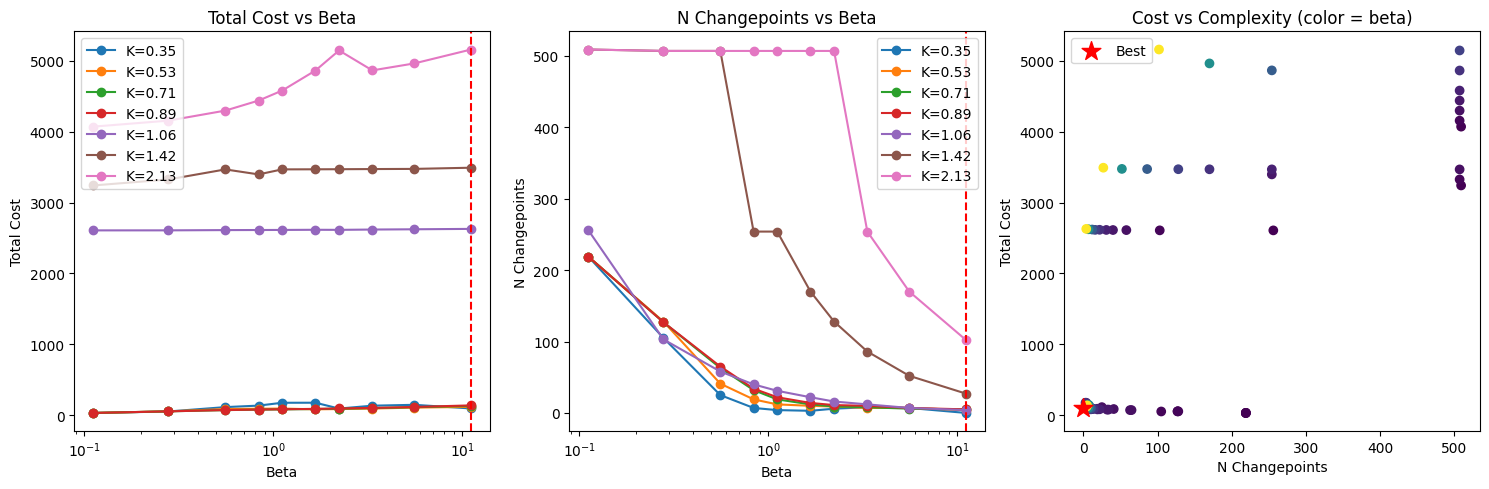

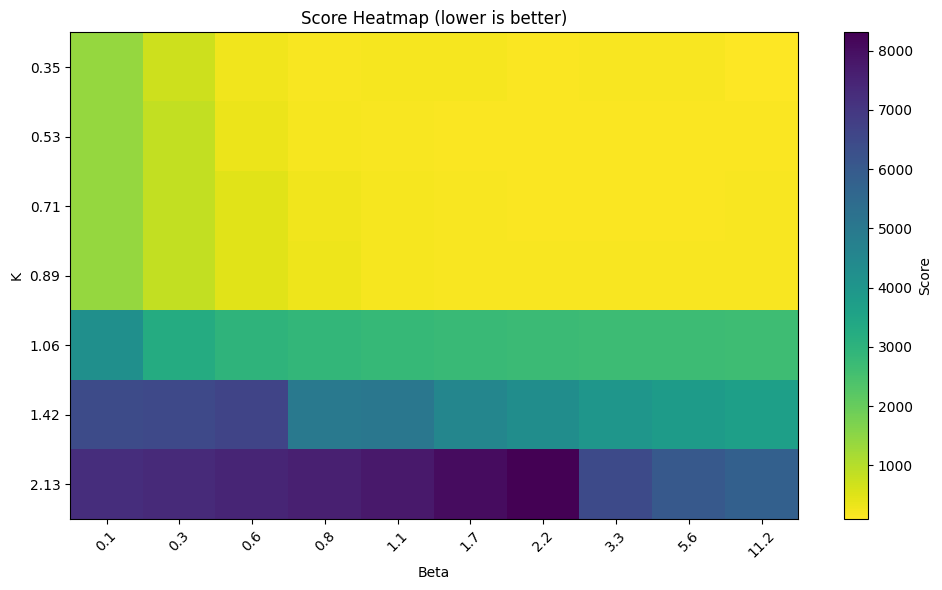

In [16]:
# Example 1: Cross-validation for a single loss function (Huber)
# Using Scenario 2 as example

y_example = data["Scenario 2"]
true_sig_example = true_signals["Scenario 2"]

# Run CV with BIC criterion
cv_result_huber = cv_changepoint_params(
    y=y_example,
    loss='huber',
    true_signal=true_sig_example,
    criterion='bic',
    verbose=True
)

# Visualize results
plot_cv_results(cv_result_huber)